# Spray morphology analysis for pMDI Spray Images

This program reads output of image preprocessing script and attempts to define the spray spatial and temporay boundary.

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 04/02/2025
    
    Multiphase Flow Laboratory
    Monash University, Australia


In [50]:
import h5py
import numpy as np
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget

from matplotlib import rc
rc('animation', html='html5')

import matplotlib.animation as animation
from IPython.display import HTML

matplotlib.rcParams['animation.embed_limit'] = 2**128

In [2]:
filename="/Users/dduke/Desktop/20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0001.h5"

# Open up file and leave it open for reading frames on the fly (save RAM).
H=h5py.File(filename,'r')
labels=H['spray_boundary_detection/labels1_felzenszwalb']
boundary=H['spray_boundary_detection/labels3_sprayBoundaryContiguous']
edges=H['spray_boundary_detection/edges_sprayBoundaryContiguous']
print(labels.shape)

(6439, 920, 896)


## Find which times spray is present

In [3]:
streamwiseIntegral = np.nanmean(boundary[...],axis=1)
spatialIntegral = np.nanmean(streamwiseIntegral,axis=1)

kernel = np.hanning(32)
smoothedIntegral = np.convolve(spatialIntegral, kernel / np.sum(kernel), 'same')    

In [4]:
# Spray is present when the spatial average is more than 1% of the maximum.
threshold=0.01
sprayOn = smoothedIntegral>threshold;

# Find largest contiguous region of spray
transitions = np.where(np.diff(sprayOn))[0] # transitions through the threshold
durations = np.diff(transitions)            # time between each transition
for longestDurations in durations[np.flipud(np.argsort(durations))]: # sort longest to shortest
    idx = np.where(durations==longestDurations)[0][0] # index to current in loop
    if not sprayOn[transitions[idx]]: # only if it's a rising edge
        t0,t1 = transitions[idx],transitions[idx+1] # take this transition
        break

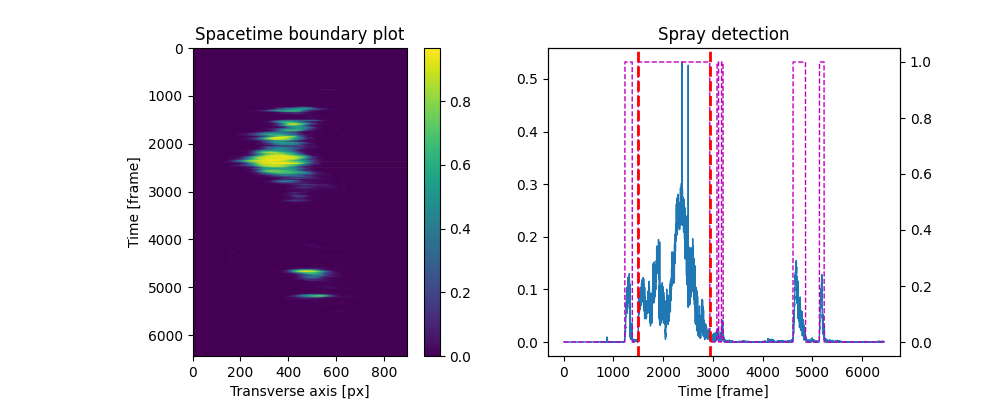

In [5]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(121)
y=int(boundary.shape[1]/2)
p=plt.imshow(streamwiseIntegral)
ax.set_aspect(0.2)
plt.colorbar(p)
plt.xlabel('Transverse axis [px]')
plt.ylabel('Time [frame]')
plt.title('Spacetime boundary plot');

ax=fig.add_subplot(122)
plt.title("Spray detection");
plt.xlabel('Time [frame]');
plt.plot(spatialIntegral,lw=1);
ax.twinx();
plt.plot(sprayOn,lw=1,ls='--',c='m');
plt.axvline(t0,ls='--',c='r',lw=2); plt.axvline(t1,ls='--',c='r',lw=2);
#plt.show();

## Animation
Check for any failed labelling/segmentations.

In [6]:
fig=plt.figure(dpi=120)

p1=plt.imshow( np.log10(labels[0,...]+1) , vmin=0, vmax=3 , animated=True )
plt.colorbar(p1)#,shrink=.6)
text = plt.text(0,-10,0)

#plt.title("Frame 0");
#plt.show();

def animate(i):
    p1.set_data(np.log10(labels[i,...]+1))
    text.set_text("Frame %i" % i);
    return [p1]

#iterable=range(0,labels.shape[0],5)
iterable=range(t0,t1)
ani = animation.FuncAnimation(fig, animate, frames=iterable, interval=40, blit=True)
plt.close();

In [7]:
#HTML(ani.to_jshtml());
#HTML(ani.to_html5_video());

#ani

## Find spray centroids

Get centroid at every Y , fit a line through them.
Do this for every frame where spray exists.

In [8]:
xx, yy = np.meshgrid(range(boundary.shape[2]),range(boundary.shape[1]))

def findCentroids(xx, yy, zz):
    width=np.nansum( zz, axis=1 )+1e-12
    transverseCentroids= np.nansum( xx*zz , axis=1 )/width
    transverseCentroids[width<10]=np.nan # mask centroids where the width is too small (<10px)
    deltas=np.hstack((np.diff(transverseCentroids),0))
    transverseCentroids[np.abs(deltas)>10]=np.nan # mask centroids where there is a sudden unphysical jump >10px/px
    return transverseCentroids

iterable=range(t0,t1) #range(boundary.shape[0])
transverseCentroids = np.array([ findCentroids(xx,yy,boundary[i,...]) for i in tqdm(iterable) ])

  0%|          | 0/1441 [00:00<?, ?it/s]

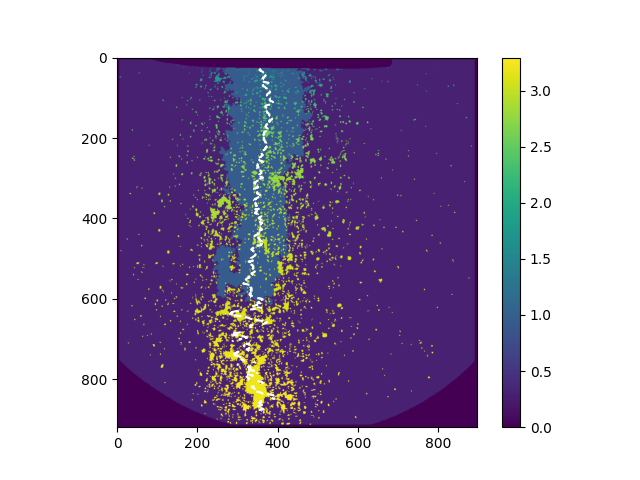

In [9]:
fig=plt.figure()
i=int((t0+t1)/2)
p=plt.imshow(np.log10(labels[i,...]+1));
plt.plot(findCentroids(xx,yy,boundary[i,...]), np.arange(boundary.shape[1]), c='w', ls='--')
plt.colorbar(p);

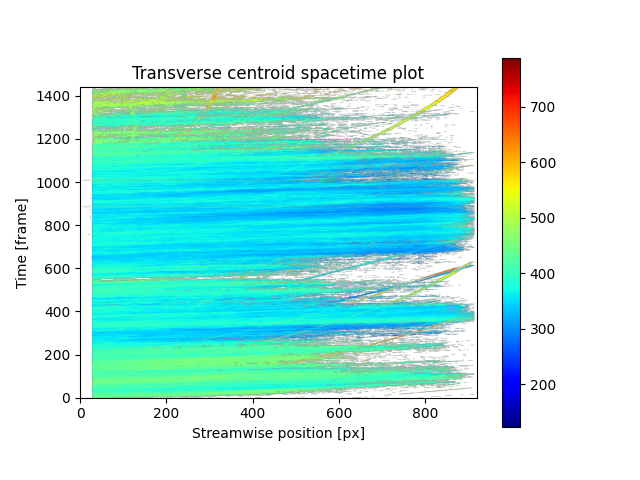

In [10]:
fig=plt.figure()
ax=fig.add_subplot(111)
p=plt.imshow(transverseCentroids,cmap='jet');
ax.invert_yaxis();
plt.xlabel("Streamwise position [px]"); 
plt.ylabel("Time [frame]");plt.title("Transverse centroid spacetime plot");
ax.set_aspect(0.5);
plt.colorbar(p);

# Find targeting angle, cone angle, width
Find the global origin of the spray.
Then make a vector from the most upstream centroid to downstream one to get the angle.
Then go perpendicularly outward from this point to find the width and angles.

Streamwise origin is X= 29 ± 3.7 px


/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/3680319813.py:12: RuntimeWarning: invalid value encountered in divide
  origin_err = np.sqrt( np.nanmean(output[:,2]/output[:,3]**2) - np.nanmean(output[:,1]/output[:,3])**2 )
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/3680319813.py:16: RuntimeWarning: invalid value encountered in divide
  plt.plot(output[:,0]+t0,output[:,1]/output[:,3],lw=1);


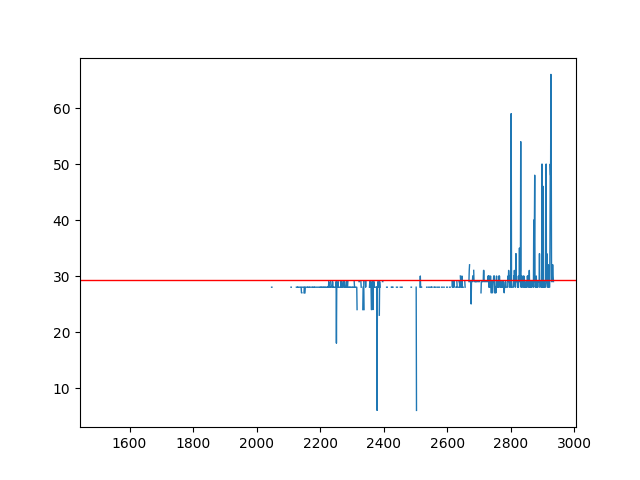

In [11]:
# Find origin in streamwise direction as first sane non-NaN centroid value at each frame.
output=[]
for i in range(0,t1-t0): # loop over valid time domain of spray only
    origin_streamwise=np.where(~np.isnan(transverseCentroids[i,:]))[0] 
    if len(origin_streamwise)>0:
        if (origin_streamwise[0] < 100): # within 100 px of edge of image.
            weight = np.sum(boundary[i,...])
            output.append((i,origin_streamwise[0]*weight,(origin_streamwise[0]*weight)**2,weight))

output=np.array(output)
origin_streamwise = np.nanmean(output[:,1])/np.nanmean(output[:,3])
origin_err = np.sqrt( np.nanmean(output[:,2]/output[:,3]**2) - np.nanmean(output[:,1]/output[:,3])**2 )
print("Streamwise origin is X= %.0f ± %.1f px" % (origin_streamwise,origin_err))

fig=plt.figure()
plt.plot(output[:,0]+t0,output[:,1]/output[:,3],lw=1);
plt.axhline(origin_streamwise,c='r',lw=1);

Transverse origin is Y= 424 ± 1.0 px


/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/2297650338.py:6: RuntimeWarning: Mean of empty slice
  origin_transverse = np.nanmean(transverseCentroids[i,x0:x0+25]) # average centroid of first 25 streamwise positions
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/2297650338.py:17: RuntimeWarning: invalid value encountered in divide
  plt.plot(output[:,0]+t0,output[:,1]/output[:,3],lw=1);


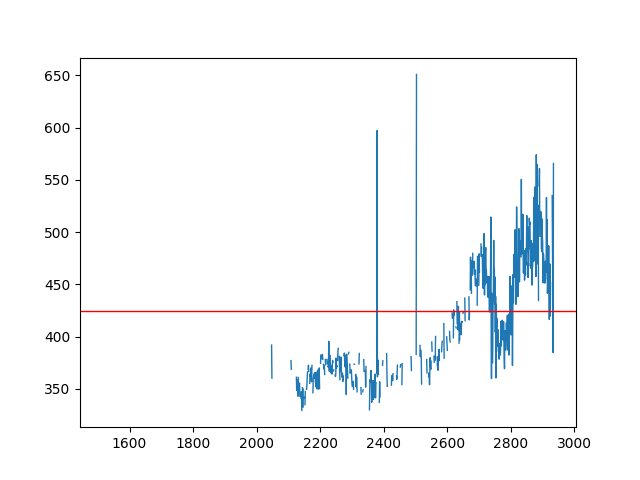

In [12]:
# Find origin in transverse direction by averaging first few streamwise positions for all frames

x0=int(origin_streamwise)
output=[]
for i in range(0,t1-t0): # loop over valid time domain of spray only
    origin_transverse = np.nanmean(transverseCentroids[i,x0:x0+25]) # average centroid of first 25 streamwise positions
    weights = np.nansum(boundary[i,...]) # weight the influence by the area of the spray.
    output.append((i, origin_transverse * weights, (origin_transverse * weights)**2, weights))

output=np.array(output)
origin_transverse = np.nanmean(output[:,1])/np.nanmean(output[:,3])
y0=int(origin_transverse)
origin_err = np.sqrt( np.nanmean(output[:,2]) - np.nanmean(output[:,1])**2 ) / np.nansum(output[:,3])
print("Transverse origin is Y= %.0f ± %.1f px" % (origin_transverse,origin_err))

fig=plt.figure()
plt.plot(output[:,0]+t0,output[:,1]/output[:,3],lw=1);
plt.axhline(origin_transverse,c='r',lw=1);

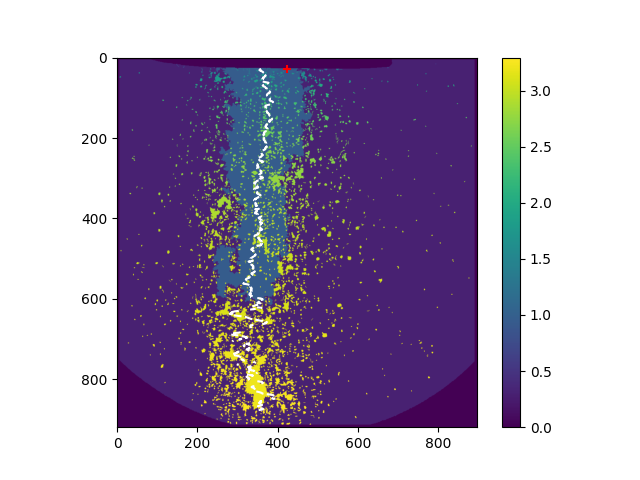

In [13]:
fig=plt.figure()
i=int((t0+t1)/2)
p=plt.imshow(np.log10(labels[i,...]+1));
plt.plot(findCentroids(xx,yy,boundary[i,...]), np.arange(boundary.shape[1]), c='w', ls='--')
plt.scatter((y0,),(x0,),c='r',marker='+');
plt.colorbar(p);

## Targeting Angle, Cone Angle and Width

In [ ]:
# Find targeting angle for all valid times , starting a slight distance downstream of the nozzle.
# SERIAL CODE

# Create arrays to hold results
targetingAngleDeg=np.zeros_like(transverseCentroids)
targetingAngleDeg[...]=np.nan

widths=np.zeros_like(transverseCentroids)
widths[...]=np.nan

coneAngleDeg=np.zeros_like(transverseCentroids)
coneAngleDeg[...]=np.nan

showPlot=True

# Set up coordinate vectors and arrays for math
x_ = np.arange(edges.shape[2]) # vector of transverse pixels
yy, xx = np.meshgrid(range(edges.shape[2]),range(edges.shape[1]))

for i in tqdm(range(transverseCentroids.shape[0])): # loop over all valid times where we have centroids
    edge_data = edges[i+t0,...] # edge detected of boundary at this time
    
    for x1 in range(x0+25,transverseCentroids.shape[1]): # loop streamwise coord - start 25px from the nozzle
        y1 = transverseCentroids[i,x1]
        
        # Find targeting angle for all valid times , starting a slight distance downstream of the nozzle.
        theta = np.atan2(y1-y0,x1-x0)*180/np.pi 
        targetingAngleDeg[i,x1] = theta

        # Find width - Find boundaries along the perpendicular
        m_tang = (x1-x0)/(y1-y0) # gradient of tangent line
        if ~np.isnan(y1):
            yPerpendicular = (-1./m_tang)*(x_-y1)+x1
            yTangent = (m_tang)*(x_-y1)+x1
            edgePerpendicular = np.zeros_like(edges[i+t0,...])
            edgePerpendicular[np.abs(xx-yPerpendicular)<2]=1.
            edgeIntersections = np.where(edgePerpendicular*edge_data)
            if len(edgeIntersections[0])>0:
                width_perp = np.sqrt((edgeIntersections[0][-1]-edgeIntersections[0][0])**2 +\
                                     (edgeIntersections[1][-1]-edgeIntersections[1][0])**2)
                widths[i,x1] = width_perp
    
                # Find cone angle formed between width extremities and the origin
                phi0 = np.atan2(edgeIntersections[1][ 0]-y0,edgeIntersections[0][ 0]-x0)*180/np.pi 
                phi1 = np.atan2(edgeIntersections[1][-1]-y0,edgeIntersections[0][-1]-x0)*180/np.pi 
    
                coneAngleDeg[i,x1] = phi1-phi0

            # Plot ONE sample result frame & streamwise posn so we can confirm that the code works.
            if (x1>300)&(i>=500)&(showPlot):
                fig=plt.figure()
                plt.title("Sample frame %i" %(i+t0))
                p=plt.imshow(edge_data[i+t0,...]);
                p=plt.imshow(edgePerpendicular,alpha=.5);
                plt.plot(x_,yTangent,ls='--'); #plt.plot(x_,yPerpendicular,ls='--');
                plt.scatter((y0,y1),(x0,x1),c='r',marker='+');
                plt.scatter(*np.flipud(edgeIntersections),1,c='w');
                plt.scatter((edgeIntersections[1][1],edgeIntersections[1][-1]),\
                            (edgeIntersections[0][1],edgeIntersections[0][-1]),marker='*',c='r');
                plt.xlim(0,900)
                plt.ylim(0,900)
                plt.gca().invert_yaxis();
                plt.text(10,80,"Cone Angle %.1f deg\nTgtg Angle %.1f deg" % (coneAngleDeg[i,x1],targetingAngleDeg[i,x1]),color='w');
                plt.show();
                showPlot=False;

In [72]:
# Find targeting angle for all valid times , starting a slight distance downstream of the nozzle.
# Functional form for parallelization.
def calculateAngleAndWidth(edge_data,centroid,x0,y0,t0,t1,showPlot=False):

    # Set up coordinate vectors and arrays for math
    x_ = np.arange(edges.shape[2]) # vector of transverse pixels
    yy, xx = np.meshgrid(range(edges.shape[2]),range(edges.shape[1]))

    # outputs vs streamwise psn for one frame
    widths_out = np.zeros((len(centroid),)) ; widths_out[:]=np.nan
    targetingAngleDeg_out = np.zeros((len(centroid),)) ; targetingAngleDeg_out[:]=np.nan
    coneAngleDeg_out = np.zeros((len(centroid),)) ; coneAngleDeg_out[:]=np.nan
    
    for x1 in range(x0+25,len(centroid)): # loop streamwise coord - start 25px from the nozzle
        y1 = centroid[x1]
        
        # Find targeting angle for all valid times , starting a slight distance downstream of the nozzle.
        theta = np.atan2(y1-y0,x1-x0)*180/np.pi 
        targetingAngleDeg_out[x1] = theta

        # Find width - Find boundaries along the perpendicular
        m_tang = (x1-x0)/(y1-y0) # gradient of tangent line
        if ~np.isnan(y1):
            yPerpendicular = (-1./m_tang)*(x_-y1)+x1
            yTangent = (m_tang)*(x_-y1)+x1
            edgePerpendicular = np.zeros_like(edge_data[...])
            edgePerpendicular[np.abs(xx-yPerpendicular)<2]=1.
            edgeIntersections = np.where(edgePerpendicular*edge_data)
            if len(edgeIntersections[0])>0:
                width_perp = np.sqrt((edgeIntersections[0][-1]-edgeIntersections[0][0])**2 +\
                                     (edgeIntersections[1][-1]-edgeIntersections[1][0])**2)
                widths_out[x1] = width_perp
    
                # Find cone angle formed between width extremities and the origin
                phi0 = np.atan2(edgeIntersections[1][ 0]-y0,edgeIntersections[0][ 0]-x0)*180/np.pi 
                phi1 = np.atan2(edgeIntersections[1][-1]-y0,edgeIntersections[0][-1]-x0)*180/np.pi 
    
                coneAngleDeg_out[x1] = phi1-phi0

            # Plot ONE sample result frame & streamwise posn so we can confirm that the code works.
            if (x1>300)&(showPlot): # about 300 px from nozzle as guess.
                fig=plt.figure()
                plt.title("Sample frame %i" %(i+t0))
                p=plt.imshow(edge_data);
                p=plt.imshow(edgePerpendicular,alpha=.5);
                plt.plot(x_,yTangent,ls='--'); #plt.plot(x_,yPerpendicular,ls='--');
                plt.scatter((y0,y1),(x0,x1),c='r',marker='+');
                plt.scatter(*np.flipud(edgeIntersections),1,c='w');
                plt.scatter((edgeIntersections[1][1],edgeIntersections[1][-1]),\
                            (edgeIntersections[0][1],edgeIntersections[0][-1]),marker='*',c='r');
                plt.xlim(0,900)
                plt.ylim(0,900)
                plt.gca().invert_yaxis();
                plt.text(10,80,"Cone Angle %.1f deg\nTgtg Angle %.1f deg" % (coneAngleDeg[i,x1],targetingAngleDeg[i,x1]),color='w');
                plt.show();
                showPlot=False;

    return widths_out, targetingAngleDeg_out, coneAngleDeg_out

In [ ]:
# Run one for test w/plot.
i=500
o = calculateAngleAndWidth(edges[i+t0,...],transverseCentroids[i,:],x0,y0,t0,t1,True)


In [ ]:
# RUN PARALLEL
print("Running morphological analysis...")
results = Parallel(n_jobs=-1,verbose=10, prefer="threads")(delayed(calculateAngleAndWidth)(edges[t0+i,...],\
        transverseCentroids[i,:],x0,y0,t0,t1) for i in range(transverseCentroids.shape[0]))

# Create arrays to hold results
widths            =np.array([ results[j][0] for j in range(len(results)) ])
targetingAngleDeg =np.array([ results[j][1] for j in range(len(results)) ])
coneAngleDeg      =np.array([ results[j][2] for j in range(len(results)) ])




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 201 tasks      | elaps

## Targeting angle plot

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/462375092.py:10: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(targetingAngleDeg,axis=1))
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/462375092.py:11: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(targetingAngleDeg,axis=1) + np.nanstd(targetingAngleDeg,axis=1),lw=1)
/Users/dduke/.local/mainenv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/462375092.py:12: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(targetingAngleDeg,axis=1) - np.nanstd(targetingAngleDeg,axis=1),lw=1)


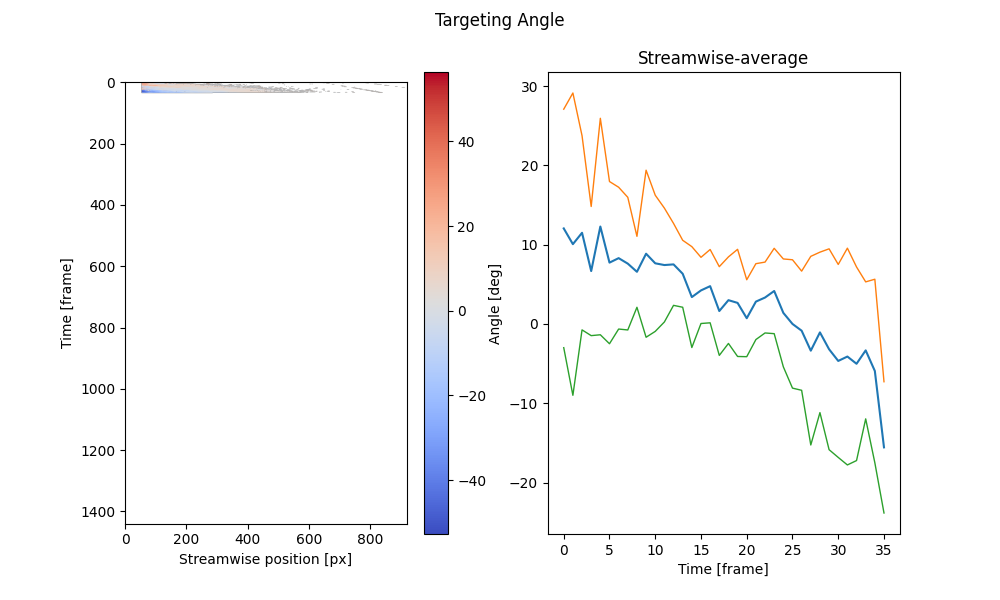

In [42]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
p=plt.imshow((targetingAngleDeg),cmap='coolwarm');
ax.set_aspect(1);
cb=plt.colorbar(p)#; cb.set_label("Degrees");
plt.xlabel("Streamwise position [px]");
plt.ylabel("Time [frame]");

ax=fig.add_subplot(122)
plt.plot(np.nanmean(targetingAngleDeg,axis=1))
plt.plot(np.nanmean(targetingAngleDeg,axis=1) + np.nanstd(targetingAngleDeg,axis=1),lw=1)
plt.plot(np.nanmean(targetingAngleDeg,axis=1) - np.nanstd(targetingAngleDeg,axis=1),lw=1)
plt.suptitle("Targeting Angle");
plt.xlabel('Time [frame]');
plt.ylabel('Angle [deg]'); 
plt.title('Streamwise-average');

## Cone Angle plot

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/1702132610.py:10: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(coneAngleDeg,axis=1))
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/1702132610.py:11: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(coneAngleDeg,axis=1) + np.nanstd(targetingAngleDeg,axis=1),lw=1)
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/1702132610.py:12: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(coneAngleDeg,axis=1) - np.nanstd(targetingAngleDeg,axis=1),lw=1)


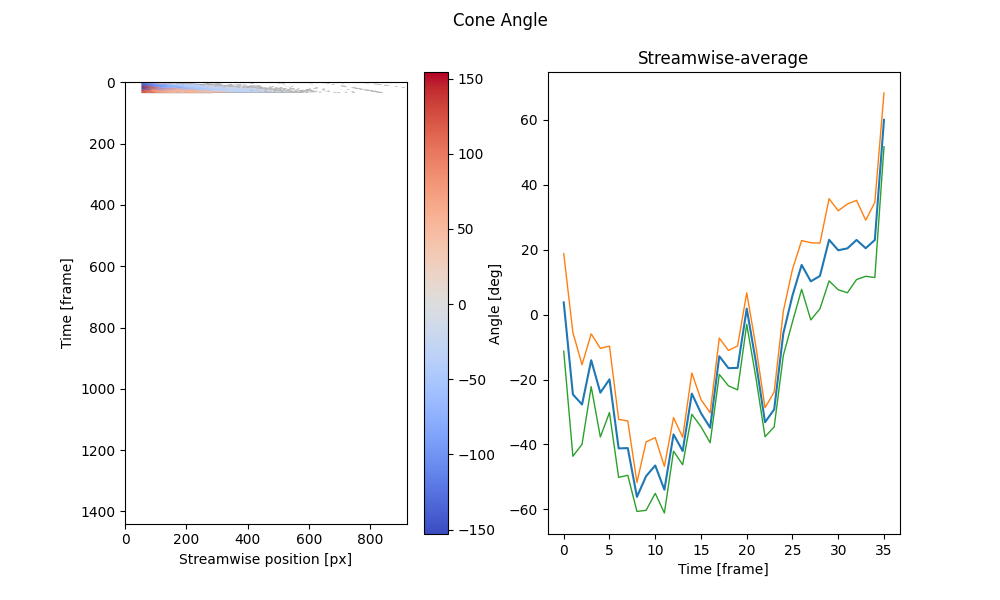

In [44]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
p=plt.imshow((coneAngleDeg),cmap='coolwarm');
ax.set_aspect(1);
cb=plt.colorbar(p)#; cb.set_label("Degrees");
plt.xlabel("Streamwise position [px]");
plt.ylabel("Time [frame]");

ax=fig.add_subplot(122)
plt.plot(np.nanmean(coneAngleDeg,axis=1))
plt.plot(np.nanmean(coneAngleDeg,axis=1) + np.nanstd(targetingAngleDeg,axis=1),lw=1)
plt.plot(np.nanmean(coneAngleDeg,axis=1) - np.nanstd(targetingAngleDeg,axis=1),lw=1)
plt.suptitle("Cone Angle");
plt.xlabel('Time [frame]');
plt.ylabel('Angle [deg]'); 
plt.title('Streamwise-average');

## Width plot

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/2022592449.py:10: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(widths,axis=1))
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/2022592449.py:11: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(widths,axis=1) + np.nanstd(targetingAngleDeg,axis=1),lw=1)
/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_67454/2022592449.py:12: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(widths,axis=1) - np.nanstd(targetingAngleDeg,axis=1),lw=1)


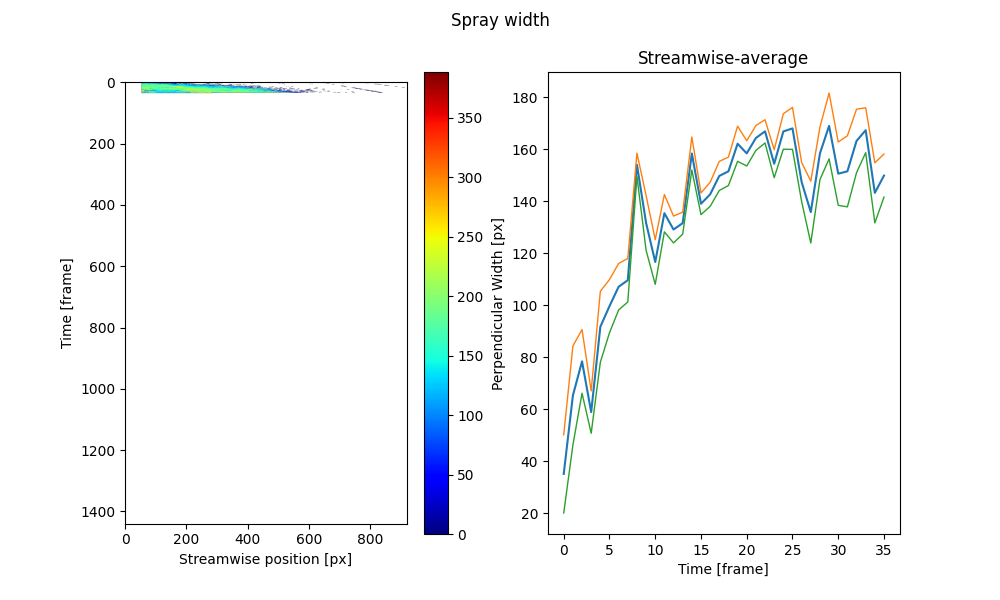

In [46]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(121)
p=plt.imshow((widths),cmap='jet');
ax.set_aspect(1);
cb=plt.colorbar(p)#; cb.set_label("Degrees");
plt.xlabel("Streamwise position [px]");
plt.ylabel("Time [frame]");

ax=fig.add_subplot(122)
plt.plot(np.nanmean(widths,axis=1))
plt.plot(np.nanmean(widths,axis=1) + np.nanstd(targetingAngleDeg,axis=1),lw=1)
plt.plot(np.nanmean(widths,axis=1) - np.nanstd(targetingAngleDeg,axis=1),lw=1)
plt.suptitle("Spray width");
plt.xlabel('Time [frame]');
plt.ylabel('Perpendicular Width [px]'); 
plt.title('Streamwise-average');